# Reprogramming

The reprogramming dataset from *Biddy, B. A. et al. Nature 564, 219–224 (2018)*. This dataset has multiple time points for both clonal and state measurements. 

**Key components**: 
    
* Part I: Infer transition map using clones from all time points
    
* Part II: Infer transition map from end-point clones
    
* Part III: Infer transition map from state information alone
    
* Part IV: Predict early fate bias on day 3

In [1]:
import cospar as cs
import numpy as np 

In [2]:
cs.logging.print_version()
cs.settings.verbosity=2
cs.settings.set_figure_params(format='png',dpi=75,fontsize=14) # use png to reduce file size. 

cs.settings.data_path='CellTag_data' # A relative path to save data. If not existed before, create a new one.
cs.settings.figure_path='CellTag_figure' # A relative path to save figures. If not existed before, create a new one.

Running cospar 0.2.0 (python 3.8.12) on 2022-02-07 22:21.


## Loading data

In [3]:
adata_orig=cs.datasets.reprogramming()

In [4]:
adata_orig=cs.pp.initialize_adata_object(adata_orig)

Time points with clonal info: ['Day12' 'Day15' 'Day21' 'Day28' 'Day6' 'Day9']


In [5]:
cs.hf.update_time_ordering(adata_orig,updated_ordering=['Day6', 'Day9','Day12', 'Day15', 'Day21', 'Day28'])

The cells are barcoded over 3 rounds during the entire differentiation process. There are multiple ways to assemble the barcodes on day 0, day 3, and day 13 into a clonal ID. Below, we provide three variants: 
    
* Concatenate barcodes on day 0 and day 13, as in the original analysis (`adata_orig.obsm['X_clone_Concat_D0D3']`, the default); 

* Concatenate barcodes on day 0, day 3, and day 13 (`adata_orig.obsm['X_clone_Concat_D0D3D13']`);

* No concatenation; each cell has up to 3 barcodes (`adata_orig.obsm['X_clone_NonConcat_D0D3D13']`). 

The last choice keeps the nested clonal structure in the data. You can choose any one of the clonal arrangement for downstream analysis, by setting `adata_orig.obsm['X_clone']=adata_orig.obsm['X_clone_Concat_D0D3']`. The three clonal arrangements give very similar fate prediction.


In [6]:
adata_orig

AnnData object with n_obs × n_vars = 18803 × 28001
    obs: 'time_info', 'state_info', 'reprogram_trajectory', 'failed_trajectory', 'Reference_fate_bias'
    uns: 'clonal_time_points', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering'
    obsm: 'X_clone', 'X_clone_Concat_D0D3', 'X_clone_Concat_D0D3D13', 'X_clone_NonConcat_D0D3D13', 'X_emb', 'X_pca'

In [7]:
cs.hf.check_available_choices(adata_orig)

Available transition maps: []
Available clusters: ['Reprogrammed', 'Failed', 'Others']
Available time points: ['Day6' 'Day9' 'Day12' 'Day15' 'Day21' 'Day28']
Clonal time points: ['Day6' 'Day9' 'Day12' 'Day15' 'Day21' 'Day28']


In [8]:
re_propressing=False
if re_propressing:
    cs.pp.get_highly_variable_genes(adata_orig)
    cs.pp.remove_cell_cycle_correlated_genes(adata_orig,corr_threshold=0.03,confirm_change=True)
    cs.pp.get_X_pca(adata_orig,n_pca_comp=40)
    cs.pp.get_X_emb(adata_orig,n_neighbors=20,umap_min_dist=0.3)
    #cs.pp.get_state_info(adata_orig,n_neighbors=20,resolution=0.5) # if this is changed, the cluster name used later will be wrong.
    cs.pl.embedding(adata_orig,color='time_info')

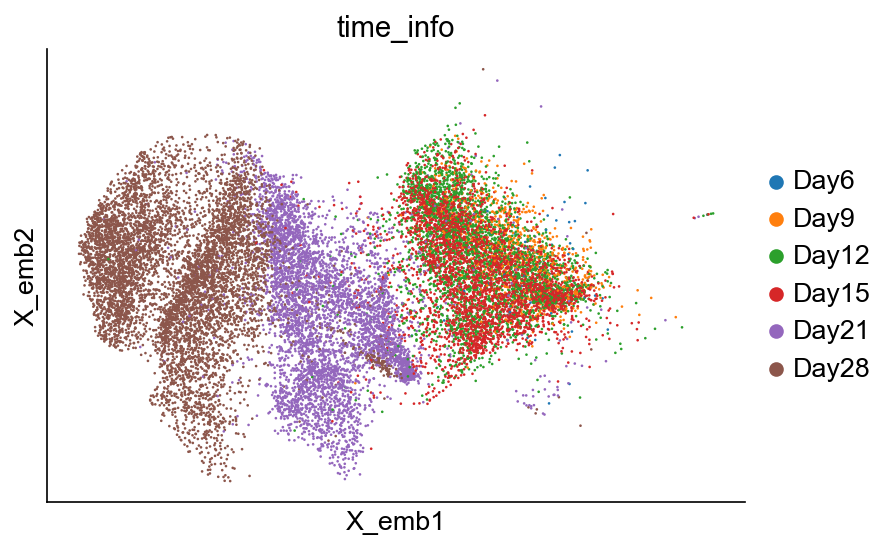

In [9]:
cs.pl.embedding(adata_orig,color='time_info')

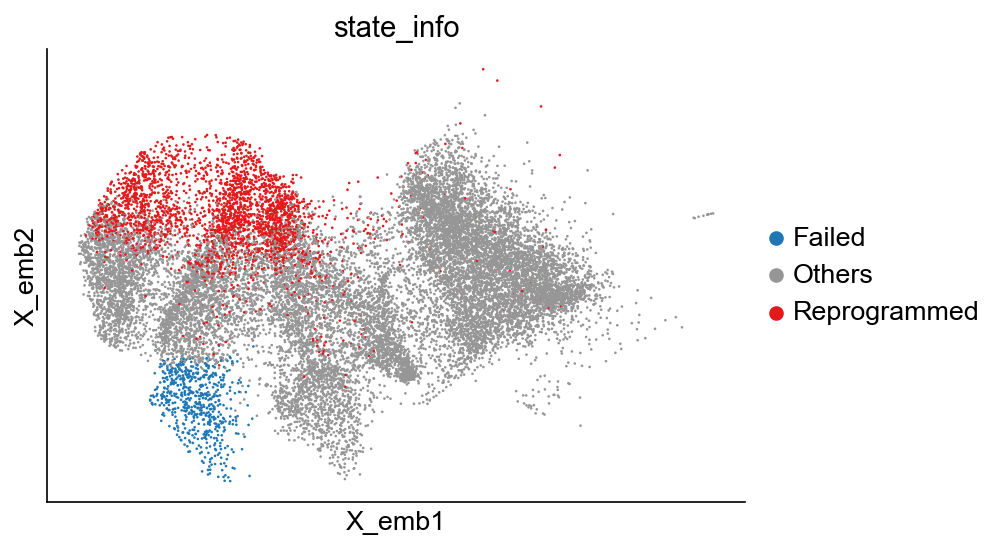

In [10]:
cs.pl.embedding(adata_orig,color='state_info')

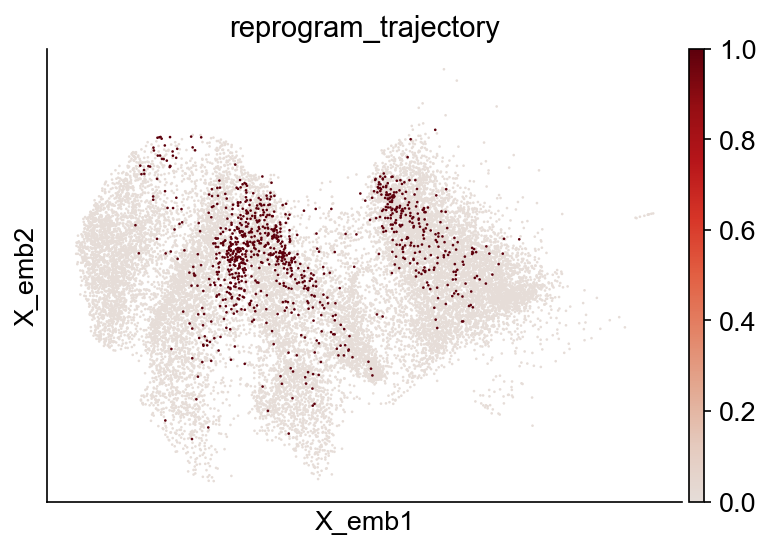

In [11]:
adata_orig.obs['reprogram_trajectory']=adata_orig.obs['reprogram_trajectory'].astype(int)
cs.pl.embedding(adata_orig,color='reprogram_trajectory')

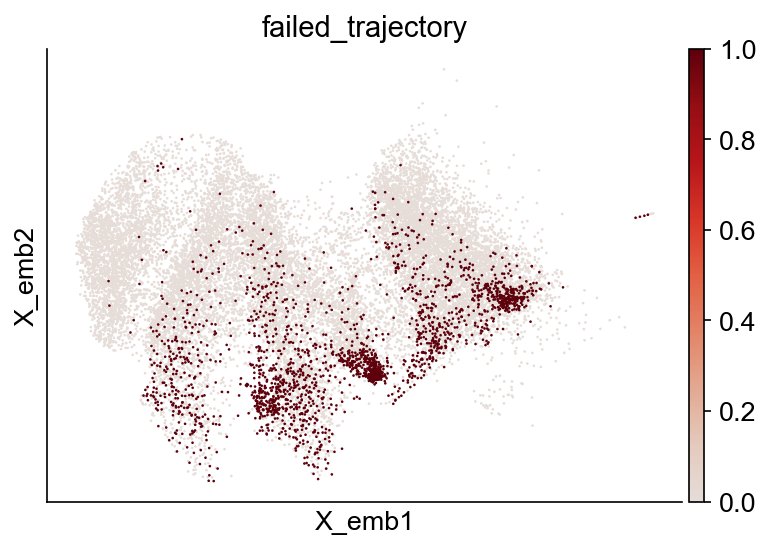

In [12]:
adata_orig.obs['failed_trajectory']=adata_orig.obs['failed_trajectory'].astype(int)
cs.pl.embedding(adata_orig,color='failed_trajectory')

### Basic clonal analysis

100%|██████████| 1451/1451 [00:01<00:00, 792.99it/s]


Data saved at adata.uns['clonal_fate_bias']


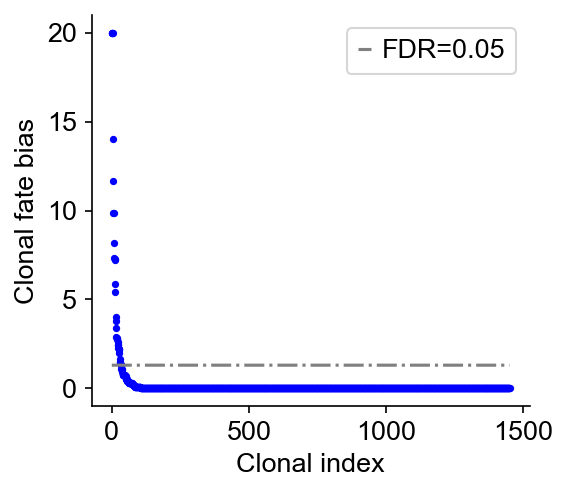

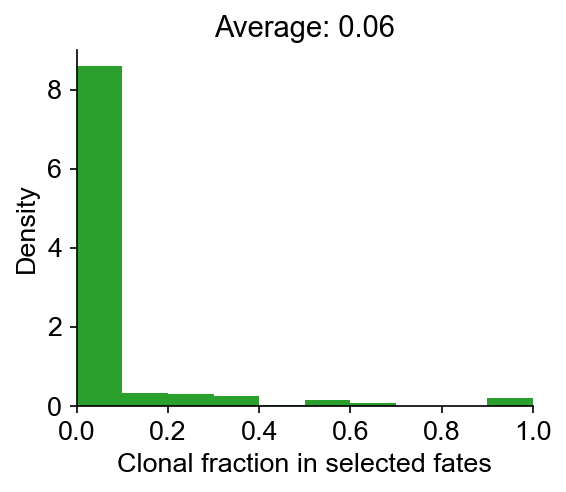

In [13]:
cs.tl.clonal_fate_bias(adata_orig,selected_fate='Reprogrammed',alternative='two-sided') 
cs.pl.clonal_fate_bias(adata_orig) 

In [14]:
result=adata_orig.uns['clonal_fate_bias']
result

Clone_ID  Clone_size       Q_value  Fate_bias  \
0         1014      2382.0  1.000000e-20  20.000000   
1          611      1908.0  1.000000e-20  20.000000   
2          600       780.0  1.000000e-20  20.000000   
3         1188       289.0  1.000000e-20  20.000000   
4          545       283.0  9.769878e-15  14.010111   
...        ...         ...           ...        ...   
1446       497         4.0  1.000000e+00  -0.000000   
1447       496         1.0  1.000000e+00  -0.000000   
1448       494        22.0  1.000000e+00  -0.000000   
1449       504         1.0  1.000000e+00  -0.000000   
1450      1450         3.0  1.000000e+00  -0.000000   

      clonal_fraction_in_target_fate  
0                           0.371537  
1                           0.265199  
2                           0.014103  
3                           0.446367  
4                           0.007067  
...                              ...  
1446                        0.000000  
1447                        1.000000  
1448                        0.227273  
1449                        0.000000  
1450                        0.000000  

[1451 rows x 5 columns]

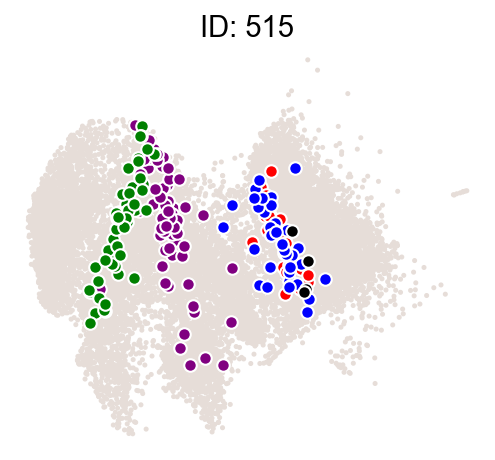

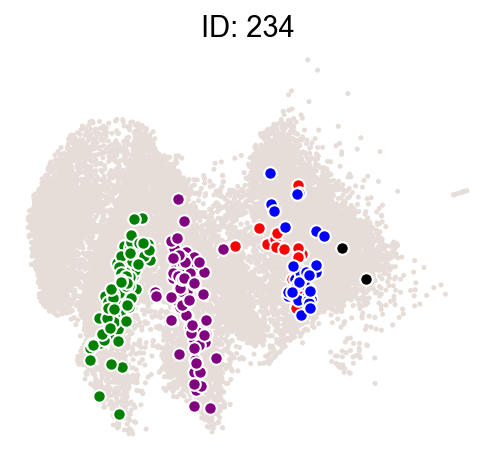

In [15]:
ids=result['Clone_ID'][8:10]
#ids=[324,313,446,716,367]
cs.pl.clones_on_manifold(adata_orig,selected_clone_list=ids) 

## Part I: Infer transition map using clones from all time points

### Map inference

Running it the first time takes ~20 mins, ~17 mins of which are used to compute the similarity matrix. When it is run again, it only takes ~3 mins.

In [16]:
adata=cs.tmap.infer_Tmap_from_multitime_clones(adata_orig,clonal_time_points=['Day15','Day21'],
        later_time_point='Day28',smooth_array=[15,10,5],sparsity_threshold=0.2,
                intraclone_threshold=0.2)

Trying to set attribute `.uns` of view, copying.


------Compute the full Similarity matrix if necessary------
------Infer transition map between initial time points and the later time one------
--------Current initial time point: Day15--------
Step 1: Select time points
Number of multi-time clones post selection: 179
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=15
Iteration 2, Use smooth_round=10
Iteration 3, Use smooth_round=5
Convergence (CoSpar, iter_N=3): corr(previous_T, current_T)=0.929
Iteration 4, Use smooth_round=5
Convergence (CoSpar, iter_N=4): corr(previous_T, current_T)=0.995
--------Current initial time point: Day21--------
Step 1: Select time points
Number of multi-time clones post selection: 226
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=15
Iteration 2, Use smooth_round=10
Iteration 3, Use smooth_round=5
Convergence (CoSpar, iter_N=3): corr(previous_T, current_T)=0.921
Iteration 4,

In [17]:
cs.hf.check_available_map(adata)
adata.uns['available_map']

['transition_map', 'intraclone_transition_map']

### Save or load pre-computed data

This can be used to save adata with maps computed from different tools or parameters.
Usually, different parameter choices will result in different `data_des`, a prefix to identify the anndata.
Saving an adata would print the `data_des`, which can be used to load the corresponding adata.

In [18]:
save_data=False
if save_data:
    cs.hf.save_map(adata)
    
load_data=False
if load_data:
    #file_path='CellTag_data/cospar_MultiTimeClone_Later_FullSpace0_t*Day15*Day21*Day28_adata_with_transition_map.h5ad'
    adata=cs.hf.read(file_path)


In [19]:
cs.hf.check_available_choices(adata)

Available transition maps: ['transition_map', 'intraclone_transition_map']
Available clusters: ['Reprogrammed', 'Failed', 'Others']
Available time points: ['Day15' 'Day21' 'Day28']
Clonal time points: ['Day15' 'Day21' 'Day28']


### Plotting

#### Single-cell transitions

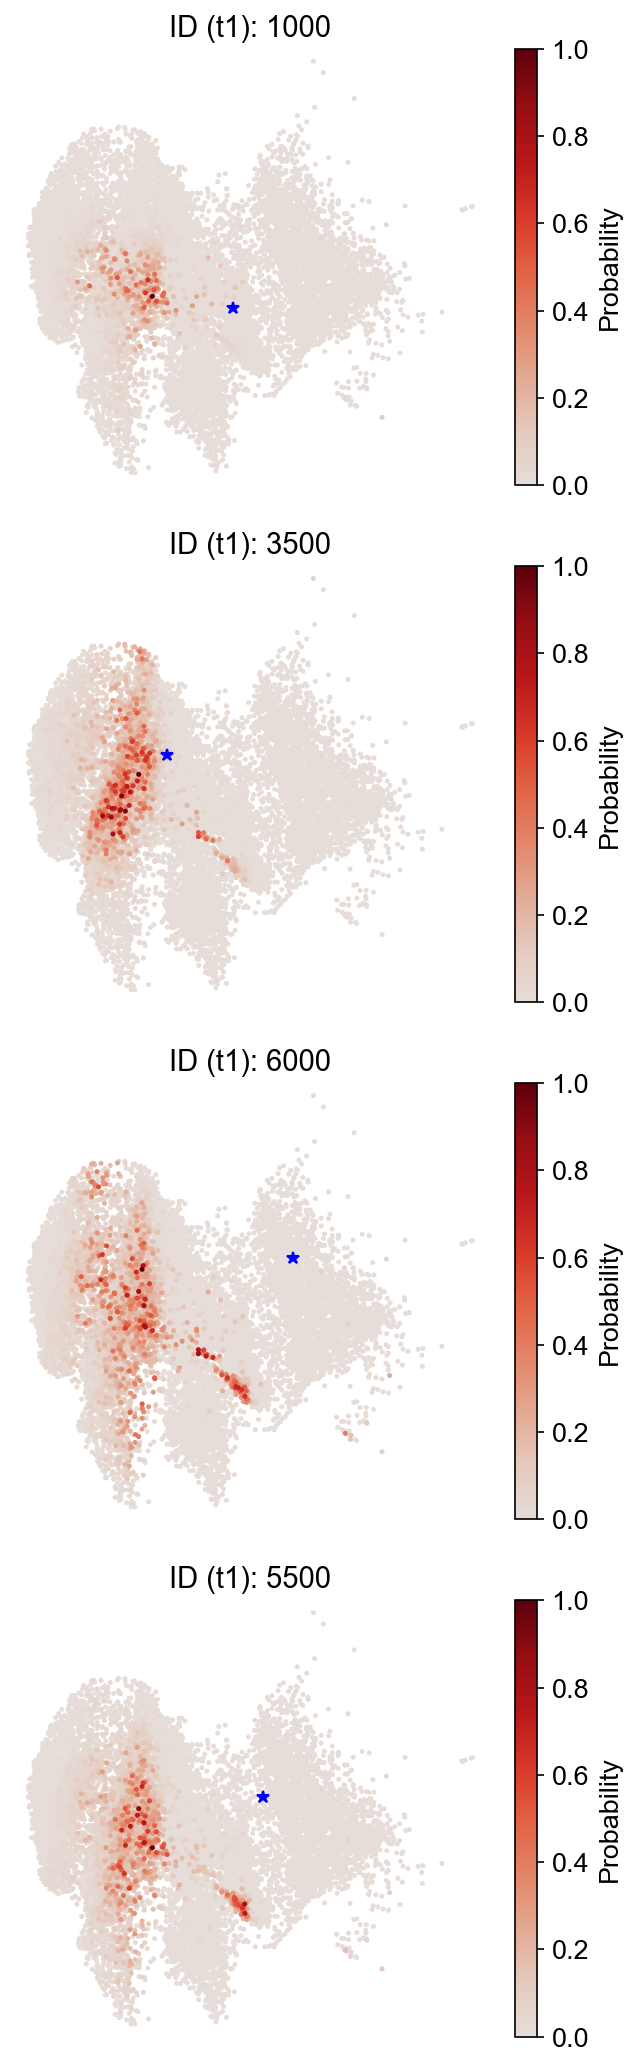

In [20]:
selected_state_id_list=[1000,3500,6000,5500]

cs.pl.single_cell_transition(adata,selected_state_id_list=selected_state_id_list,
                                    source='transition_map',map_backward=False)

#### Fate map

Results saved at adata.obs['fate_map_transition_map_Reprogrammed']
Results saved at adata.obs['fate_map_transition_map_Failed']


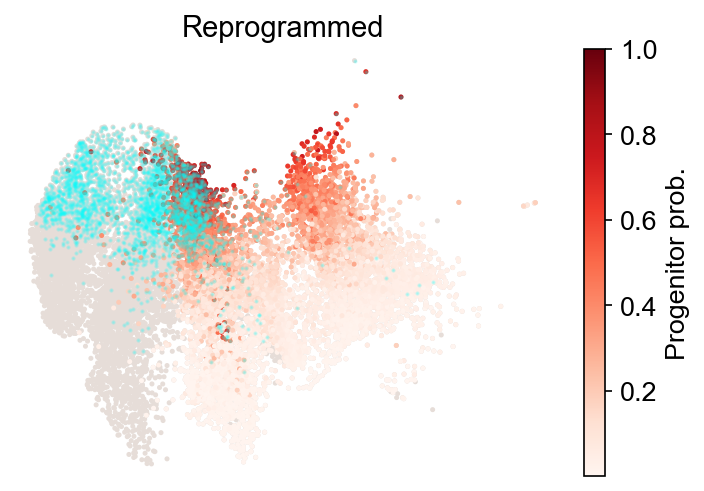

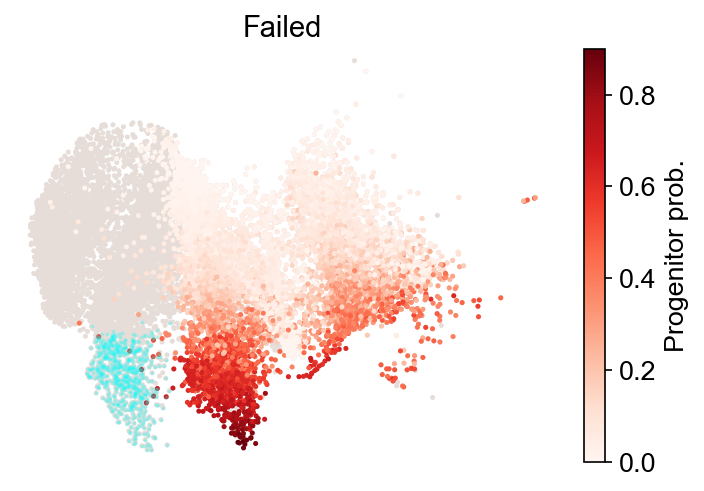

In [21]:
cs.tl.fate_map(adata,selected_fates=['Reprogrammed','Failed'],source='transition_map',map_backward=True)
cs.pl.fate_map(adata,selected_fates=['Reprogrammed','Failed'],source='transition_map',plot_target_state=True)

#### Fate bias

Results saved at adata.obs['fate_map_transition_map_Reprogrammed']
Results saved at adata.obs['fate_map_transition_map_Failed']
Results saved at adata.obs['fate_bias_transition_map_Reprogrammed*Failed']


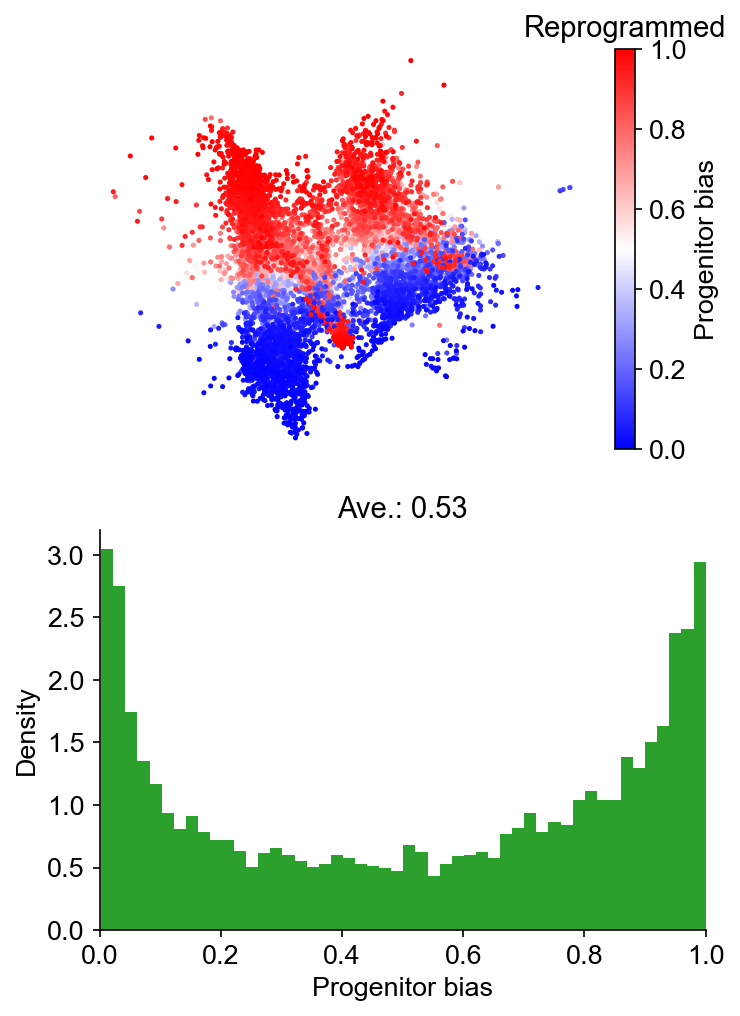

In [22]:
cs.tl.fate_bias(adata,selected_fates=['Reprogrammed','Failed'],source='transition_map',map_backward=True,method='norm-sum')
cs.pl.fate_bias(adata,selected_fates=['Reprogrammed','Failed'],source='transition_map',plot_target_state=False,background=False,show_histogram=True)

#### Identify differentially expressed genes

Results saved at adata.obs['fate_map_transition_map_Reprogrammed']
Results saved at adata.obs['fate_map_transition_map_Failed']
Results saved at adata.obs['fate_bias_transition_map_Reprogrammed*Failed']
Results saved at adata.obs[f'progenitor_transition_map_Reprogrammed'] and adata.obs[f'diff_trajectory_transition_map_Reprogrammed']
Results saved at adata.obs[f'progenitor_transition_map_Failed'] and adata.obs[f'diff_trajectory_transition_map_Failed']


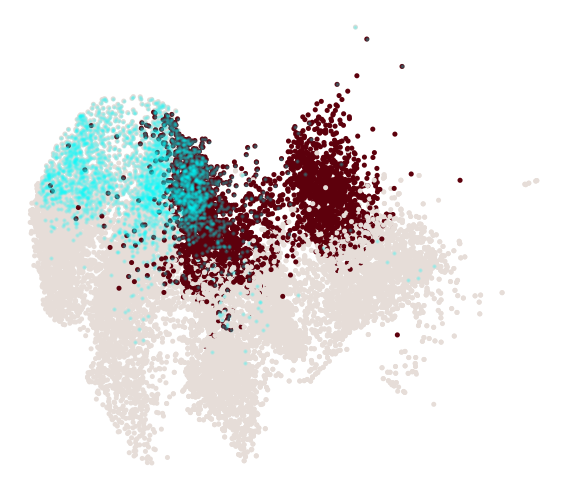

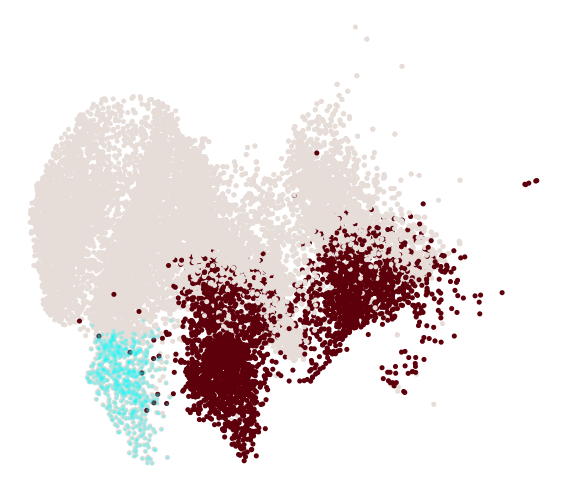

In [23]:
selected_fates=['Reprogrammed','Failed']
cs.tl.progenitor(adata,selected_fates,source='transition_map',sum_fate_prob_thresh=0.2,bias_threshold_A=0.5,bias_threshold_B=0.5)
cs.pl.progenitor(adata,selected_fates,source='transition_map')

#### Differential genes for two ancestor groups

In [24]:
cell_group_A=np.array(adata.obs[f'progenitor_transition_map_Reprogrammed'])
cell_group_B=np.array(adata.obs[f'progenitor_transition_map_Failed'])
dge_gene_A, dge_gene_B=cs.tl.differential_genes(adata,cell_group_A=cell_group_A,cell_group_B=cell_group_B,FDR_cutoff=0.05)

In [25]:
# All, ranked, DGE genes for group A
dge_gene_A

index    gene         Qvalue     mean_1     mean_2     ratio
0        35  Col3a1  6.087368e-223   0.807060   5.999794 -1.953668
1        57  Col1a2  1.345045e-161   0.297653   3.076256 -1.651340
2        41    Spp1  3.197045e-207  10.833703  32.003143 -1.479702
3         9  Col1a1   0.000000e+00   2.036317   7.257215 -1.443333
4         6   Il6st   0.000000e+00   2.108766   7.134142 -1.387648
...     ...     ...            ...        ...        ...       ...
4828   5607    Tbk1   2.006752e-02   0.224493   0.224873 -0.000448
4829   5172  Sec23a   1.005175e-02   0.344517   0.344837 -0.000344
4830   6047   Ints5   3.603720e-02   0.226673   0.226857 -0.000216
4831   5737    Taf2   2.431736e-02   0.278397   0.278525 -0.000144
4832   6101    Dgkq   3.874214e-02   0.144835   0.144836 -0.000002

[4833 rows x 6 columns]

#### Gene trend along the trajectory

The results are based on pre-computed dynamic trajectories from the preceding step. It is
better to use the `intraclone_transition_map`. First, show the expression dynamics along the failed trajectory:

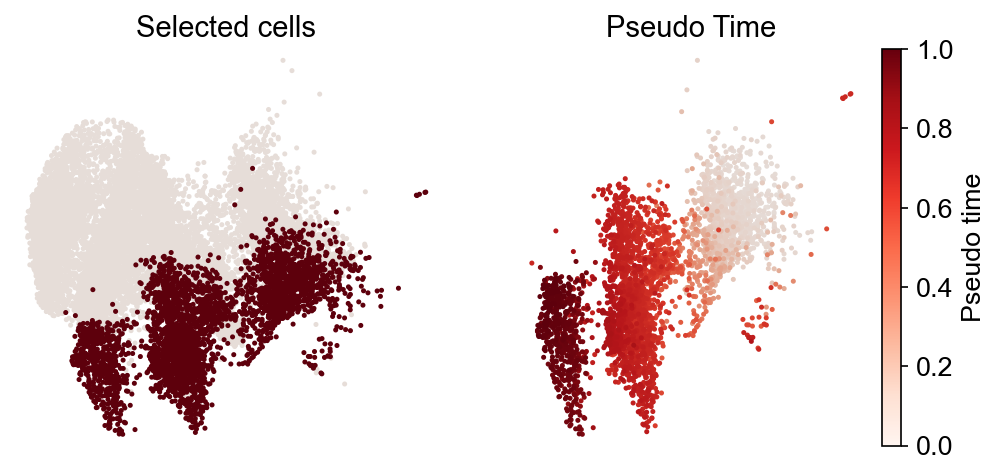

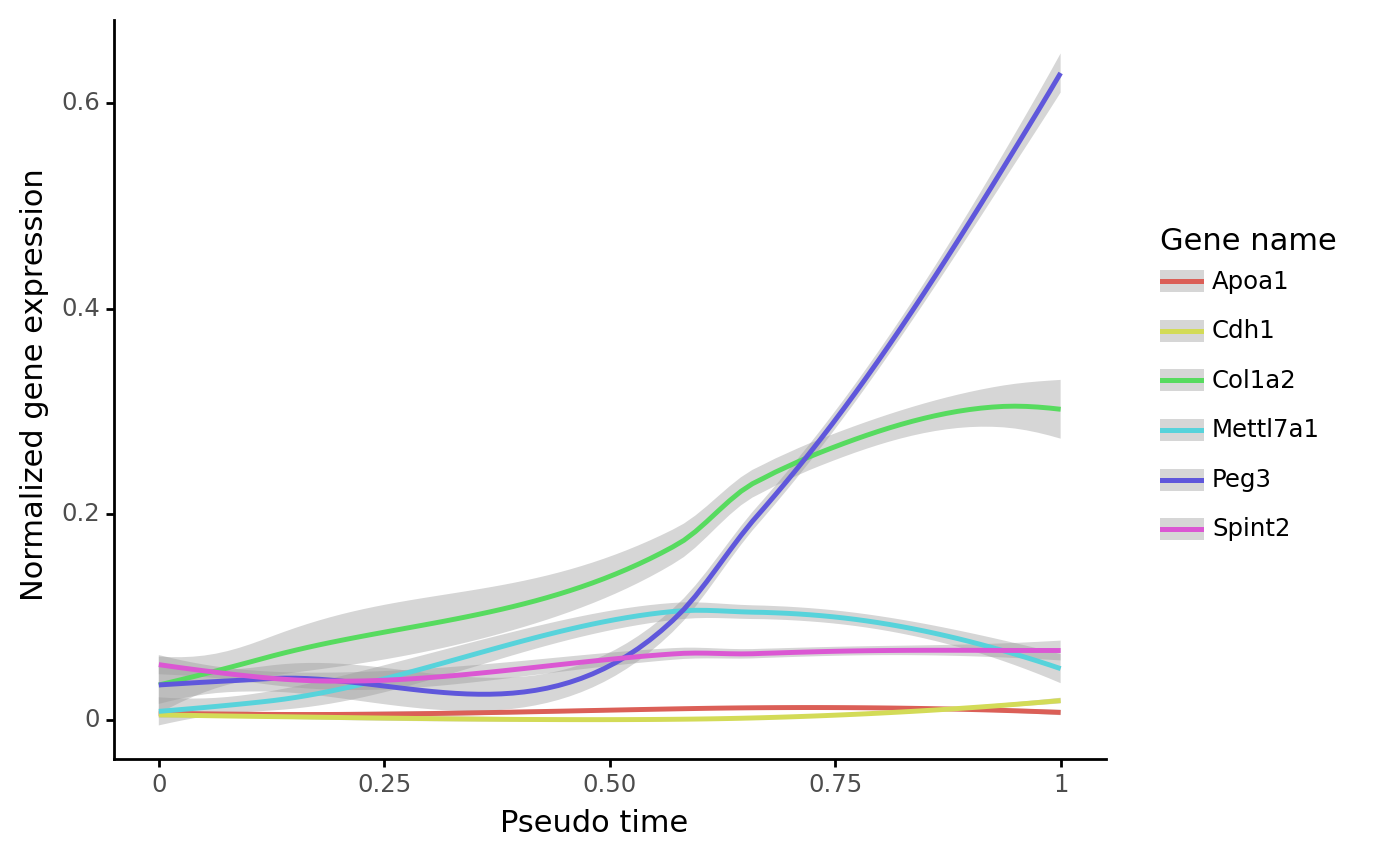

In [26]:
gene_name_list=['Col1a2','Apoa1','Peg3','Spint2','Mettl7a1','Cdh1']
selected_fate='Failed'
cs.pl.gene_expression_dynamics(adata,selected_fate,gene_name_list, traj_threshold=0.1,  
      invert_PseudoTime=True)

Expression dynamics along the reprogramming trajectory:

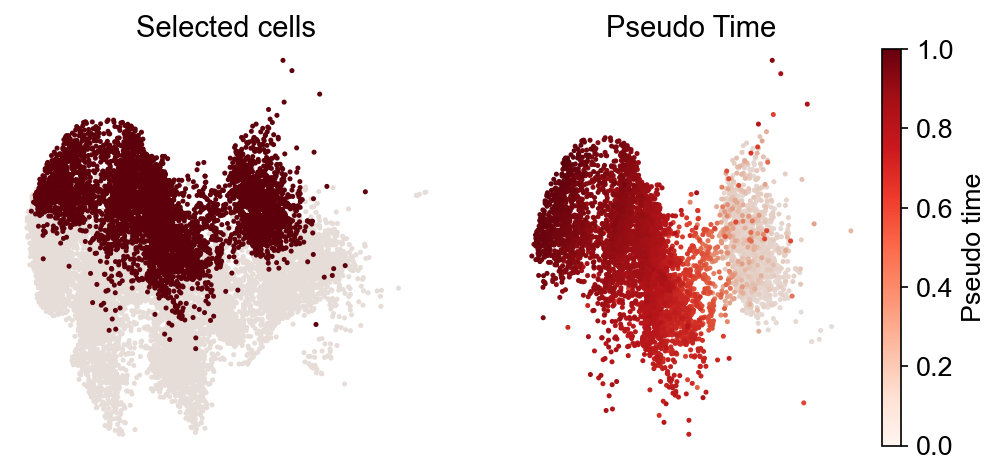

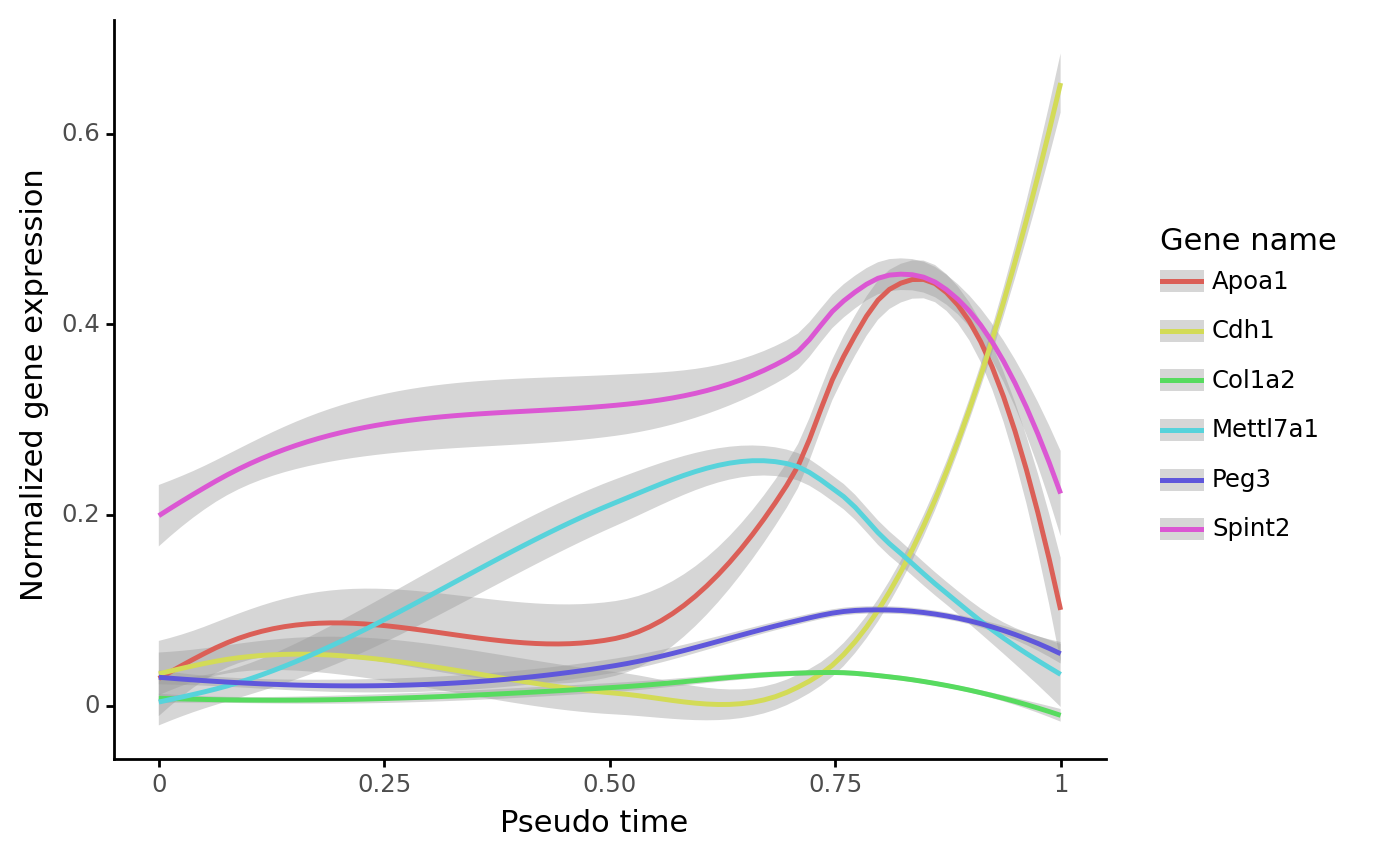

In [27]:
gene_name_list=['Col1a2','Apoa1','Peg3','Spint2','Mettl7a1','Cdh1']
selected_fate='Reprogrammed'
cs.pl.gene_expression_dynamics(adata,selected_fate,gene_name_list, traj_threshold=0.1,  
      invert_PseudoTime=True)

## Part II: Infer transition map from end-point clones¶

It takes ~12 mins to compute for the first time (excluding the time for computing similarity matrix); and ~5 mins later.

In [28]:
adata=cs.tmap.infer_Tmap_from_one_time_clones(adata_orig,initial_time_points=['Day15','Day21'],
        later_time_point='Day28',initialize_method='OT',OT_cost='SPD',
                        smooth_array=[15,10,5],sparsity_threshold=0.2)

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


--------Infer transition map between initial time points and the later time one-------
--------Current initial time point: Day15--------
Step 0: Pre-processing and sub-sampling cells-------
Step 1: Use OT method for initialization-------
Load pre-computed shortest path distance matrix
Compute new custom OT matrix
Use uniform growth rate
OT solver: duality_gap
Finishing computing optial transport map, used time 51.17336821556091
Step 2: Jointly optimize the transition map and the initial clonal states-------
-----JointOpt Iteration 1: Infer initial clonal structure
-----JointOpt Iteration 1: Update the transition map by CoSpar
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=15
Iteration 2, Use smooth_round=10
Iteration 3, Use smooth_round=5
Convergence (CoSpar, iter_N=3): corr(previous_T, current_T)=0.875
Iteration 4, Use smooth_round=5
Convergence (CoSpar, iter_N=4): corr(previous_T, current_T)=0.992
Convergence (JointOpt, iter_N=1): corr(previous_T, current_T)=0.276


Trying to set attribute `.uns` of view, copying.


--------Current initial time point: Day21--------
Step 0: Pre-processing and sub-sampling cells-------
Step 1: Use OT method for initialization-------
Load pre-computed shortest path distance matrix
Compute new custom OT matrix
Use uniform growth rate
OT solver: duality_gap
Finishing computing optial transport map, used time 98.62810587882996
Step 2: Jointly optimize the transition map and the initial clonal states-------
-----JointOpt Iteration 1: Infer initial clonal structure
-----JointOpt Iteration 1: Update the transition map by CoSpar
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=15
Iteration 2, Use smooth_round=10
Iteration 3, Use smooth_round=5
Convergence (CoSpar, iter_N=3): corr(previous_T, current_T)=0.896
Iteration 4, Use smooth_round=5
Convergence (CoSpar, iter_N=4): corr(previous_T, current_T)=0.987
Convergence (JointOpt, iter_N=1): corr(previous_T, current_T)=0.15
Finishing Joint Optimization, used time 162.67132997512817
-----------Total used time: 4

In [29]:
cs.hf.check_available_map(adata)
adata.uns['available_map']

['transition_map', 'OT_transition_map']

### Fate bias

Results saved at adata.obs['fate_map_transition_map_Reprogrammed']
Results saved at adata.obs['fate_map_transition_map_Failed']
Results saved at adata.obs['fate_bias_transition_map_Reprogrammed*Failed']


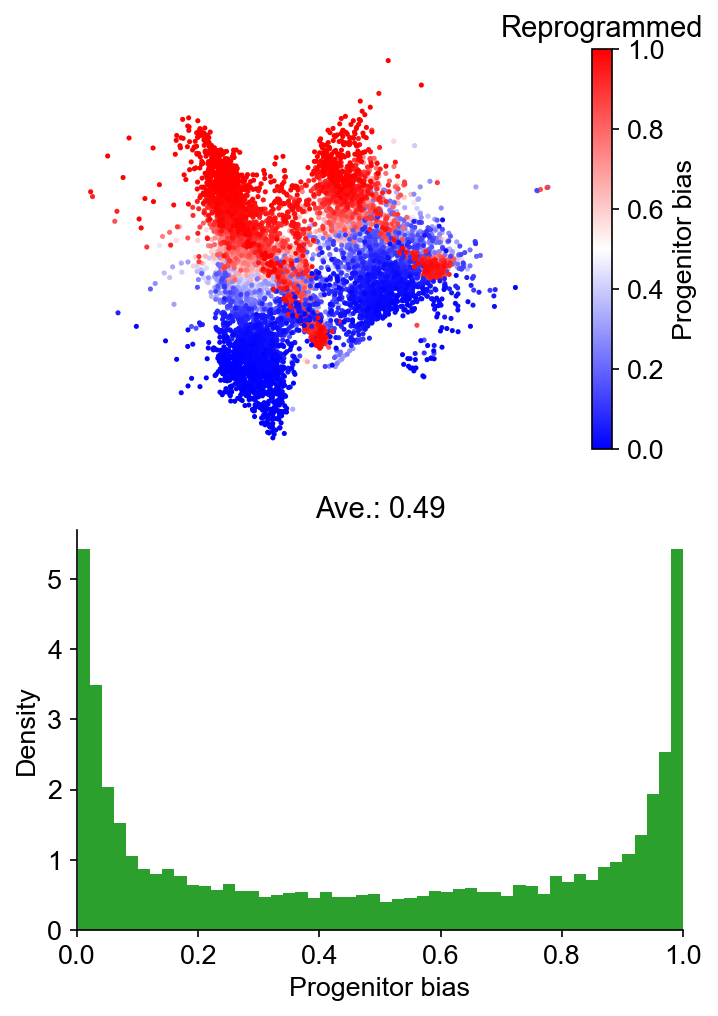

In [30]:
cs.tl.fate_bias(adata,selected_fates=['Reprogrammed','Failed'],source='transition_map',map_backward=True,method='norm-sum')
cs.pl.fate_bias(adata,selected_fates=['Reprogrammed','Failed'],source='transition_map',plot_target_state=False,background=False,show_histogram=True)

## Part III: Infer transition map from state information alone

It takes ~5 mins

In [31]:
adata=cs.tmap.infer_Tmap_from_state_info_alone(adata_orig,initial_time_points=['Day15','Day21'],
        later_time_point='Day28',initialize_method='OT',OT_cost='SPD',
                smooth_array=[15,10,5],sparsity_threshold=0.2,use_full_Smatrix=True)

Step I: Generate pseudo clones where each cell has a unique barcode-----


Trying to set attribute `.uns` of view, copying.


Step II: Perform joint optimization-----


Trying to set attribute `.uns` of view, copying.


--------Infer transition map between initial time points and the later time one-------
--------Current initial time point: Day15--------
Step 0: Pre-processing and sub-sampling cells-------
Step 1: Use OT method for initialization-------
Load pre-computed shortest path distance matrix
Compute new custom OT matrix
Use uniform growth rate
OT solver: duality_gap
Finishing computing optial transport map, used time 42.353046894073486
Step 2: Jointly optimize the transition map and the initial clonal states-------
-----JointOpt Iteration 1: Infer initial clonal structure
-----JointOpt Iteration 1: Update the transition map by CoSpar
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=15
Iteration 2, Use smooth_round=10
Iteration 3, Use smooth_round=5
Convergence (CoSpar, iter_N=3): corr(previous_T, current_T)=0.877
Iteration 4, Use smooth_round=5
Convergence (CoSpar, iter_N=4): corr(previous_T, current_T)=0.994
Convergence (JointOpt, iter_N=1): corr(previous_T, current_T)=0.301

Trying to set attribute `.uns` of view, copying.


--------Current initial time point: Day21--------
Step 0: Pre-processing and sub-sampling cells-------
Step 1: Use OT method for initialization-------
Load pre-computed shortest path distance matrix
Compute new custom OT matrix
Use uniform growth rate
OT solver: duality_gap
Finishing computing optial transport map, used time 125.77742171287537
Step 2: Jointly optimize the transition map and the initial clonal states-------
-----JointOpt Iteration 1: Infer initial clonal structure
-----JointOpt Iteration 1: Update the transition map by CoSpar
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=15
Iteration 2, Use smooth_round=10
Iteration 3, Use smooth_round=5
Convergence (CoSpar, iter_N=3): corr(previous_T, current_T)=0.897
Iteration 4, Use smooth_round=5
Convergence (CoSpar, iter_N=4): corr(previous_T, current_T)=0.984
Convergence (JointOpt, iter_N=1): corr(previous_T, current_T)=0.29
Finishing Joint Optimization, used time 114.50927495956421
-----------Total used time: 

In [32]:
cs.hf.check_available_map(adata)
adata.uns['available_map']

['transition_map', 'OT_transition_map']

### Fate bias

Results saved at adata.obs['fate_map_transition_map_Reprogrammed']
Results saved at adata.obs['fate_map_transition_map_Failed']
Results saved at adata.obs['fate_bias_transition_map_Reprogrammed*Failed']


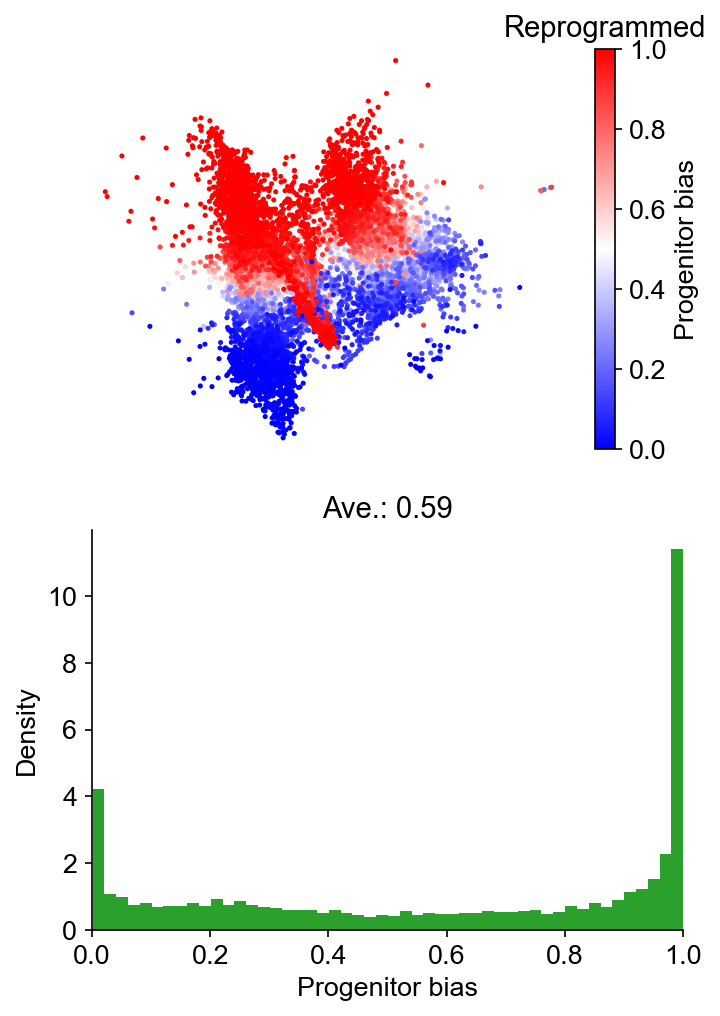

In [33]:
cs.tl.fate_bias(adata,selected_fates=['Reprogrammed','Failed'],source='transition_map',map_backward=True,method='norm-sum')
cs.pl.fate_bias(adata,selected_fates=['Reprogrammed','Failed'],source='transition_map',plot_target_state=False,background=False,show_histogram=True)

## Part IV: Predict early fate bias on day 3

### Load data

The above dataset only includes clonally-labeled states from day 6 to day 28. We load a dataset that has day-0 and day-3 states, which do not have clonal information. 


In [34]:
cs.settings.data_path='CellTag_data_full' # A relative path to save data. If not existed before, create a new one.
cs.settings.figure_path='CellTag_figure_full' # A relative path to save figures. If not existed before, create a new one.
adata_orig_1=cs.datasets.reprogramming_Day0_3_28()

In [35]:
adata_orig_1=cs.pp.initialize_adata_object(adata_orig_1)

Time points with clonal info: ['Day28']


In [36]:
cs.hf.update_time_ordering(adata_orig_1,updated_ordering=['Day0','Day3', 'Day28'])

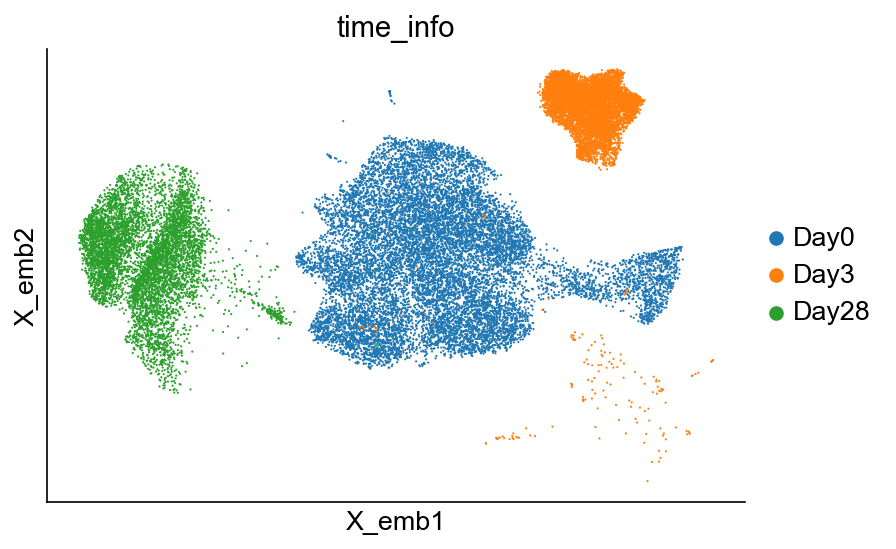

In [37]:
cs.pl.embedding(adata_orig_1,color='time_info')

In [38]:
adata_orig_1

AnnData object with n_obs × n_vars = 27718 × 28001
    obs: 'predicted_doublet', 'row_counts', 'time_info', 'state_info', 'batch'
    var: 'highly_variable-0'
    uns: 'clonal_time_points', 'data_des', 'state_info_colors', 'time_info_colors', 'time_ordering'
    obsm: 'X_clone', 'X_emb', 'X_emb_old', 'X_emb_v1', 'X_pca'

### Infer transition map from end-point clones¶
It takes ~4 mins

In [39]:
adata_1=cs.tmap.infer_Tmap_from_one_time_clones(adata_orig_1,initial_time_points=['Day3'],
    later_time_point=['Day28'],initialize_method='HighVar',smooth_array=[15,10,5], 
                        max_iter_N=[1,3],sparsity_threshold=0.2,use_full_Smatrix=True)

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


--------Infer transition map between initial time points and the later time one-------
--------Current initial time point: Day3--------
Step 0: Pre-processing and sub-sampling cells-------
Step 1: Use the HighVar method for initialization-------
Step a: find the commonly shared highly variable genes------
Highly varable gene number: 1684 (t1); 1696 (t2). Common set: 960
Step b: convert the shared highly variable genes into clonal info------


 92%|█████████▎| 888/960 [00:00<00:00, 1292.96it/s]


Total used genes=888 (no cells left)
Step c: compute the transition map based on clonal info from highly variable genes------
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=15
Iteration 2, Use smooth_round=10
Iteration 3, Use smooth_round=5
Convergence (CoSpar, iter_N=3): corr(previous_T, current_T)=0.862
Finishing initialization using HighVar, used time 158.03640127182007
Step 2: Jointly optimize the transition map and the initial clonal states-------
-----JointOpt Iteration 1: Infer initial clonal structure
-----JointOpt Iteration 1: Update the transition map by CoSpar
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=15
Iteration 2, Use smooth_round=10
Iteration 3, Use smooth_round=5
Convergence (CoSpar, iter_N=3): corr(previous_T, current_T)=0.921
Convergence (JointOpt, iter_N=1): corr(previous_T, current_T)=0.512
Finishing Joint Optimization, used time 126.52328705787659
-----------Total used time: 289.5595648288727 s ------------


### Fate bias

Use pre-computed fate map


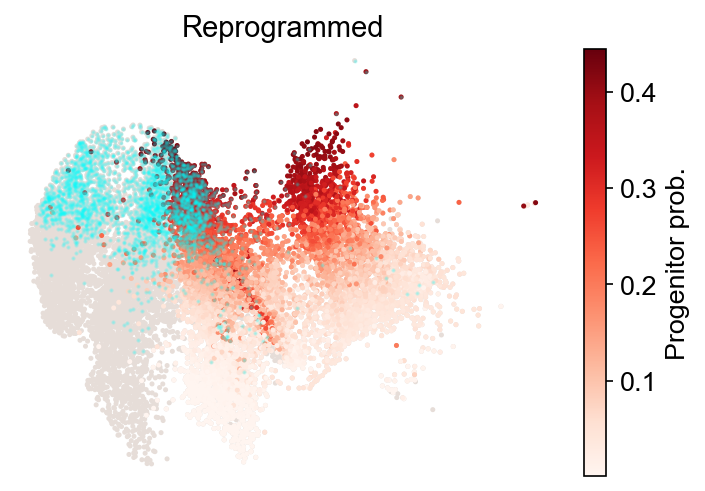

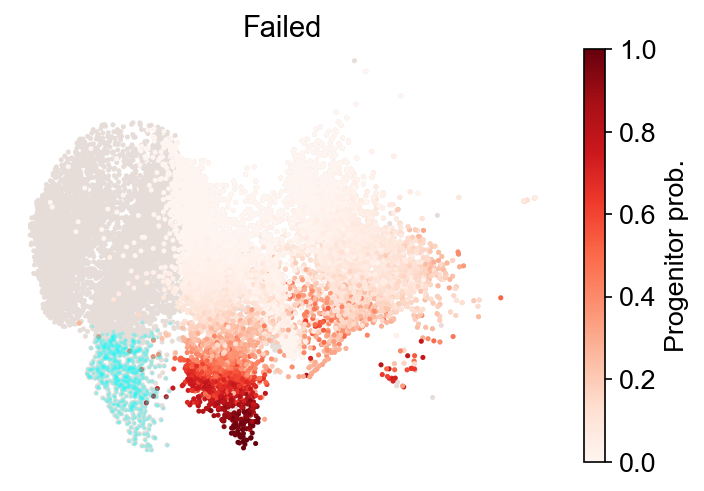

In [40]:
cs.tl.fate_map(adata,selected_fates=['Reprogrammed','Failed'],source='transition_map',map_backward=True)
cs.pl.fate_map(adata,selected_fates=['Reprogrammed','Failed'],source='transition_map',plot_target_state=True)

Results saved at adata.obs['fate_map_transition_map_Reprogrammed']
Results saved at adata.obs['fate_map_transition_map_Failed']
Results saved at adata.obs['fate_bias_transition_map_Reprogrammed*Failed']


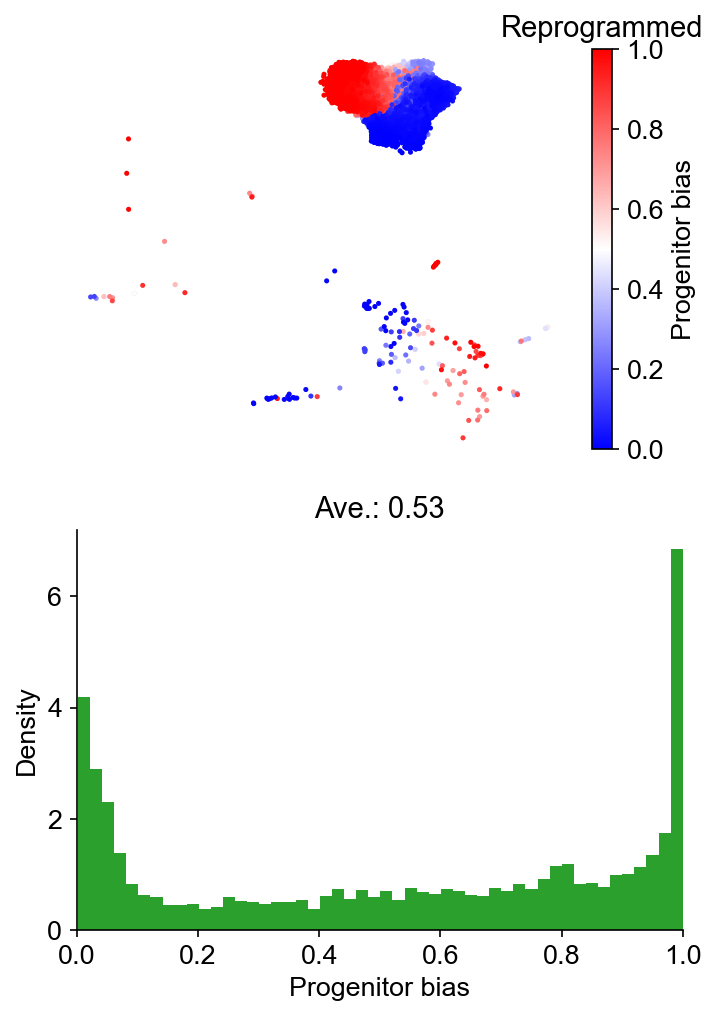

In [41]:
cs.tl.fate_bias(adata_1,selected_fates=['Reprogrammed','Failed'],source='transition_map',map_backward=True,method='norm-sum')
cs.pl.fate_bias(adata_1,selected_fates=['Reprogrammed','Failed'],source='transition_map',selected_times=['Day3'],plot_target_state=False,background=False,show_histogram=True)

### Identify ancestor populations

Results saved at adata.obs['fate_map_transition_map_Reprogrammed']
Results saved at adata.obs['fate_map_transition_map_Failed']
Results saved at adata.obs['fate_bias_transition_map_Reprogrammed*Failed']
Results saved at adata.obs[f'progenitor_transition_map_Reprogrammed'] and adata.obs[f'diff_trajectory_transition_map_Reprogrammed']
Results saved at adata.obs[f'progenitor_transition_map_Failed'] and adata.obs[f'diff_trajectory_transition_map_Failed']


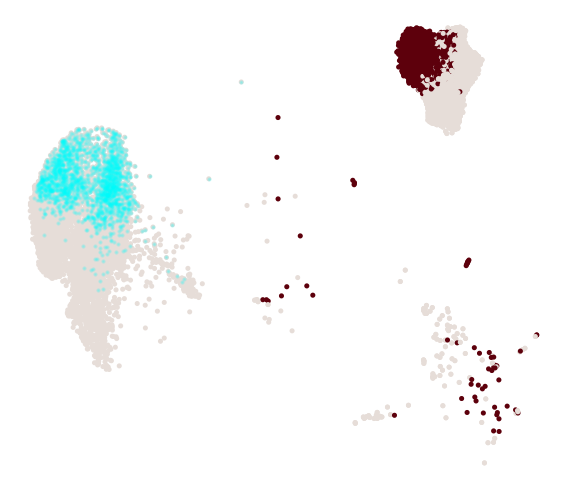

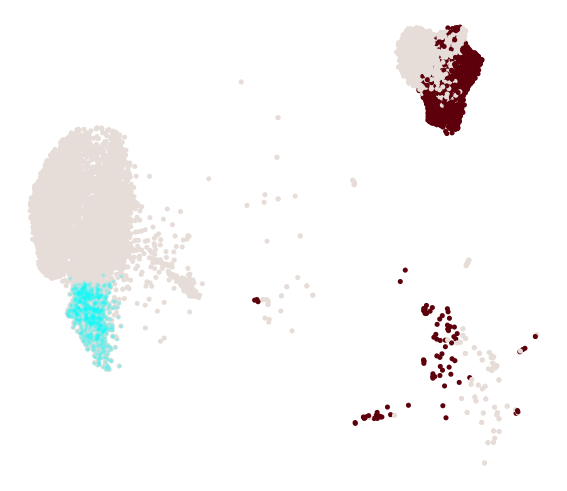

In [42]:
selected_fates=['Reprogrammed','Failed']
cs.tl.progenitor(adata_1,selected_fates,source='transition_map',sum_fate_prob_thresh=0.1,bias_threshold_A=0.5,bias_threshold_B=0.5)
cs.pl.progenitor(adata_1,selected_fates,source='transition_map')

### DGE analysis

In [43]:
cell_group_A=np.array(adata_1.obs[f'progenitor_transition_map_Reprogrammed'])
cell_group_B=np.array(adata_1.obs[f'progenitor_transition_map_Failed'])
dge_gene_A, dge_gene_B=cs.tl.differential_genes(adata_1,cell_group_A=cell_group_A,cell_group_B=cell_group_B,FDR_cutoff=0.05)

In [44]:
# All, ranked, DGE genes for group A
dge_gene_A

index     gene         Qvalue    mean_1    mean_2     ratio
0        46      Ptn  1.714648e-105  1.406754  6.237863 -1.588475
1        11     Cnn1  9.708323e-167  0.914648  4.413725 -1.499543
2        25     Thy1  6.483313e-134  0.640454  2.997786 -1.285106
3        81     Penk   4.283470e-73  0.532019  2.376845 -1.140242
4         2    Cd248   0.000000e+00  1.403314  4.151762 -1.100041
...     ...      ...            ...       ...       ...       ...
1514   3217    Fads3   2.390519e-02  0.770464  0.798334 -0.022533
1515   3353  Tmem189   3.330180e-02  0.633464  0.658867 -0.022264
1516   3590     Rere   4.966121e-02  0.542979  0.565672 -0.021064
1517   1546   Tuba1b   5.925740e-06  5.398442  5.484683 -0.019315
1518   3545    Vegfa   4.597810e-02  1.169517  1.198003 -0.018820

[1519 rows x 6 columns]

Update cluster annotation on day 3

/Users/shouwenwang/miniconda3/envs/CoSpar_test/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'state_info' as categorical


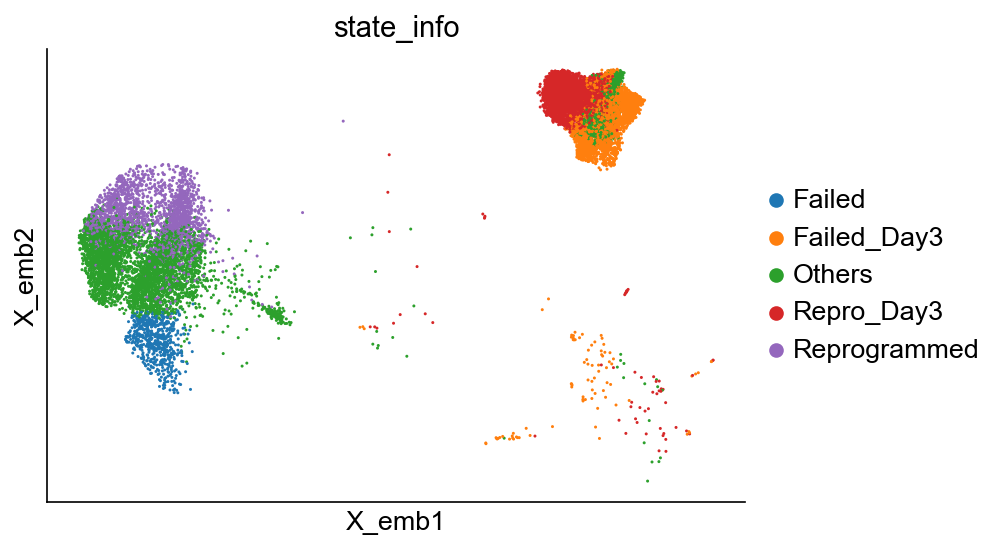

In [45]:
x_emb=adata_1.obsm['X_emb'][:,0]
state_info=np.array(adata_1.obs['state_info']).astype('>U15')
sp_idx=(cell_group_A>0) & (x_emb>0)
state_info[sp_idx]='Repro_Day3'

sp_idx=(cell_group_B>0) & (x_emb>0)
state_info[sp_idx]='Failed_Day3'
adata_1.obs['state_info']=state_info
cs.pl.embedding(adata_1,color='state_info')

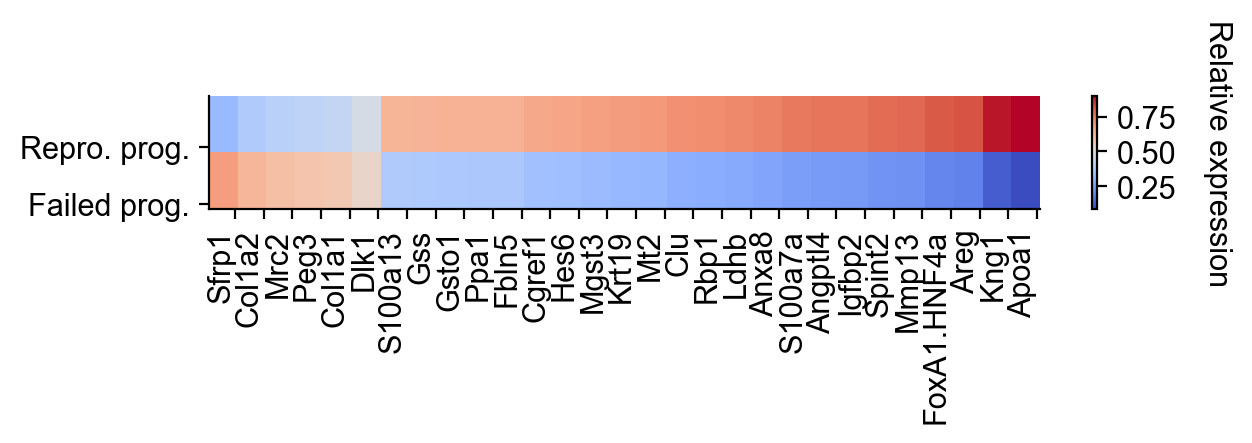

In [46]:
cs.settings.set_figure_params(fontsize=12)
gene_list=['FoxA1.HNF4a','Spint2','Apoa1', 'Hes6', 'S100a7a', 'Krt19',  'Clu',  'S100a13',
        'Ppa1', 'Mgst3',  'Angptl4','Kng1','Igfbp2','Mt2','Areg','Rbp1','Anxa8','Gsto1','Ldhb','Mmp13','Cgref1','Fbln5','Gss','Col1a2','Dlk1','Peg3','Sfrp1','Mrc2','Col1a1']

selected_fates=['Repro_Day3','Failed_Day3']
renames=['Repro. prog.','Failed prog.']

gene_expression_matrix=cs.pl.gene_expression_heat_map(adata_1,selected_genes=gene_list,
            selected_fates=selected_fates,rename_fates=renames,horizontal=True,fig_width=6.5,fig_height=2)

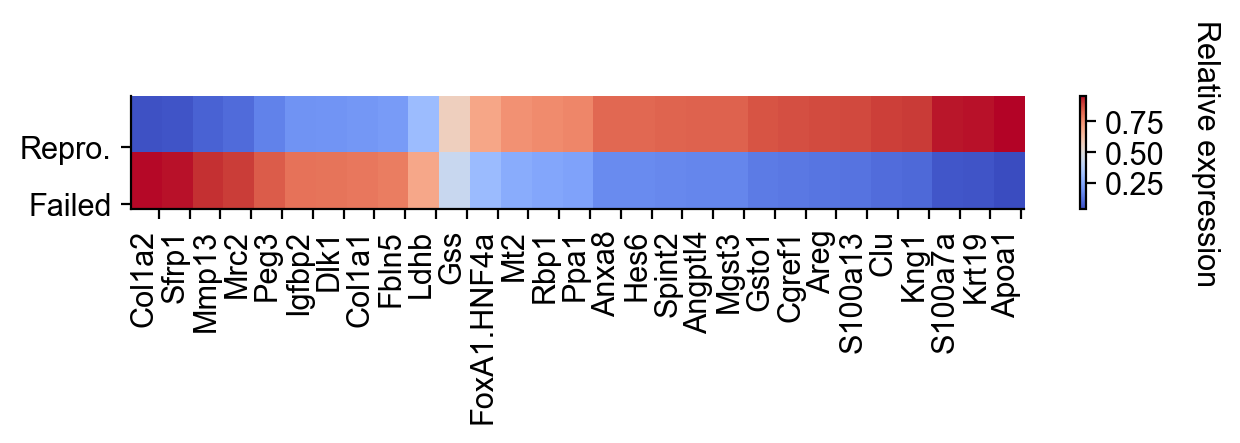

In [47]:
gene_list=['FoxA1.HNF4a','Spint2','Apoa1', 'Hes6', 'S100a7a', 'Krt19',  'Clu',  'S100a13',
        'Ppa1', 'Mgst3',  'Angptl4','Kng1','Igfbp2','Mt2','Areg','Rbp1','Anxa8','Gsto1','Ldhb','Mmp13','Cgref1','Fbln5','Gss','Col1a2','Dlk1','Peg3','Sfrp1','Mrc2','Col1a1']

selected_fates=['Reprogrammed','Failed']
renames=['Repro.','Failed']

gene_expression_matrix=cs.pl.gene_expression_heat_map(adata_1,selected_genes=gene_list,
            selected_fates=selected_fates,rename_fates=renames,horizontal=True,fig_width=6.5,fig_height=2)